# Image Quality Checker -- Text Generation Part

### **Installing Necessary Packages**

In [1]:
!pip install --no-deps accelerate
!pip install --no-deps \
  https://github.com/bitsandbytes-foundation/bitsandbytes/releases/download/continuous-release_main/bitsandbytes-1.33.7.preview-py3-none-manylinux_2_24_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 18.0 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install rouge_score
!pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c92844e4f8b84bf16d6e31f655ce3085a191a2d5203d4bb0894f487ef1c5138d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which

In [3]:
!pip install num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 6.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=796d6e184b0251834c6f0ca25e8f08faaf051524a8e50820478476399adb36ea
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt


### downloading the dataset

In [4]:
!wget -c https://huggingface.co/datasets/chaofengc/QGround-100K/resolve/main/qground.tar

--2025-07-31 05:26:04--  https://huggingface.co/datasets/chaofengc/QGround-100K/resolve/main/qground.tar
Resolving huggingface.co (huggingface.co)... 18.67.93.102, 18.67.93.22, 18.67.93.58, ...
Connecting to huggingface.co (huggingface.co)|18.67.93.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/c9/a6/c9a65426fae0e29ea878935a1739b2fd8c41f501846c1bb02afb7002e46278c3/3c40f8104033f04107a144606cb121590ebd17f8592b330e286d3e6e4e4ac5ba?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27qground.tar%3B+filename%3D%22qground.tar%22%3B&response-content-type=application%2Fx-tar&Expires=1753943164&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1Mzk0MzE2NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2M5L2E2L2M5YTY1NDI2ZmFlMGUyOWVhODc4OTM1YTE3MzliMmZkOGM0MWY1MDE4NDZjMWJiMDJhZmI3MDAyZTQ2Mjc4YzMvM2M0MGY4MTA0MDMzZjA0MTA3YTE0NDYwNmNiMTIxNTkwZWJkMTdmODU5MmIzMzBlMjg2ZD

In [5]:
!tar -xf /kaggle/working/qground.tar

### module imports

In [15]:
import json 
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, AutoModelForImageTextToText, get_scheduler, BitsAndBytesConfig
from peft import PeftModel, LoraConfig, TaskType, get_peft_model
from accelerate import Accelerator
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import evaluate

### opening the json files

In [7]:
with open('/kaggle/working/qground_dataset/qground_train.json') as f:
    train_data = json.load(f)

with open('/kaggle/working/qground_dataset/qground_test.json') as f:
    test_data = json.load(f)

In [8]:
train_data[0]

{'id': '8427827661_cauchy',
 'image': 'spaq_koniq/8427827661.jpg',
 'ann_list': [{'quality_description': 'The lighting in this picture is average, with an overall dark color tone. The focus is on the people and children in the foreground, and the features of their clothes on the snowy ground are clear. The features of the person on the left and the cat on the right are difficult to discern due to underexposure. The features of the distant snowy ground, trees, vehicles, and some buildings are relatively blurry. The overall quality of the image is considered average.',
   'segmentation_mask': 'spaq_koniq/8427827661_cauchy_8427827661.jpg'},
  {'quality_description': 'The clarity of this image is relatively high, depicting people and animals in the snow. However, there is a lack of distinction in the colors of the people. Therefore, the quality of this image is acceptable.',
   'segmentation_mask': 'spaq_koniq/8427827661_yingjie_8427827661.jpg'},
  {'quality_description': "The illumination

In [9]:
test_data[0]

{'id': '07454_zhizheng',
 'image': 'spaq_koniq/07454.jpg',
 'ann_list': [{'quality_description': 'This image has serious focusing issues, causing most of the content to be blurry. The texture and details of the main subject, the car, are almost completely lost. The background vegetation and poster are also blurry. The overall clarity is very low, therefore the quality of this image is poor.',
   'segmentation_mask': 'spaq_koniq/07454_zhizheng_07454.jpg'},
  {'quality_description': 'Overall, the lens shake is very obvious in this picture, and the content is completely unclear. In addition, there is overexposure. Therefore, overall, I personally think the quality of this picture is very poor.',
   'segmentation_mask': 'spaq_koniq/07454_XieYuxuan_07454.jpg'},
  {'quality_description': 'This image suffers from significant motion blur, resulting in a blurry and unclear main subject. It has lost most of its texture details and has a mediocre composition. Therefore, the quality of this image 

In [10]:
print("Train Size:",len(train_data))
print("Test Size:",len(test_data))

Train Size: 17663
Test Size: 1000


### showing one sample of the dataset

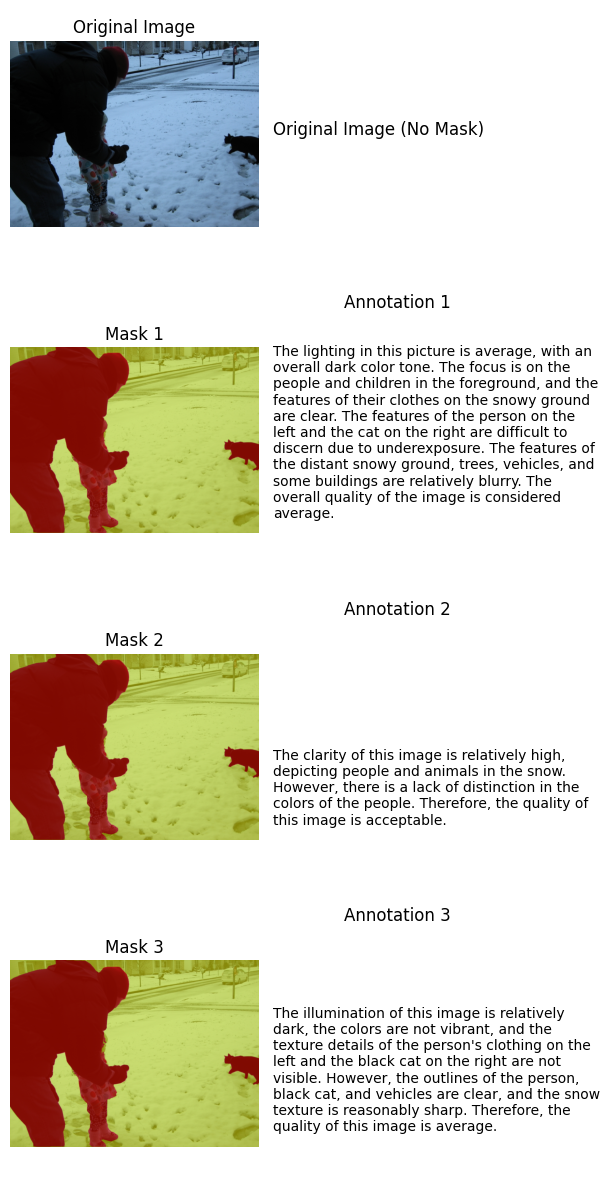

In [11]:
img_path = os.path.join('/kaggle/working/qground_dataset/images','spaq_koniq/8427827661.jpg')
img = Image.open(img_path).convert("RGB")
annotations = [l['quality_description'] for l in train_data[0]['ann_list']]
masks = [os.path.join('/kaggle/working/qground_dataset/masks',l['segmentation_mask']) for l in train_data[0]['ann_list']]


fig,ax = plt.subplots(4,2,figsize=(6,12))
yellow_red_cmap = LinearSegmentedColormap.from_list("YellowRed", ["yellow", "red"])

ax[0, 0].imshow(img)
ax[0, 0].set_title("Original Image")
ax[0, 0].axis("off")

ax[0, 1].axis("off")
ax[0, 1].text(0, 0.5, "Original Image (No Mask)", fontsize=12, wrap=True)

for i in range(3):
    mask = Image.open(masks[i]).convert("L")
    mask_np = np.array(mask) / 255.0

    ax[i+1, 0].imshow(img)
    ax[i+1, 0].imshow(mask_np, cmap=yellow_red_cmap, alpha=0.5)
    ax[i+1, 0].set_title(f"Mask {i+1}")
    ax[i+1, 0].axis("off")

    ax[i+1, 1].axis("off")
    ax[i+1, 1].set_title(f"Annotation {i+1}")
    ax[i+1, 1].text(0, 0.2, annotations[i], wrap=True, fontsize=10)

plt.tight_layout()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
if torch.cuda.is_available():
    print(f"CUDA is available. Found {torch.cuda.device_count()} GPUs.")
    for i in range(torch.cuda.device_count()):
        print(f"  - GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

CUDA is available. Found 1 GPUs.
  - GPU 0: Tesla P100-PCIE-16GB


### Importing The Model

In [14]:
model_id = 'HuggingFaceTB/SmolVLM-256M-Instruct'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
base_model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto'
)

processor = AutoProcessor.from_pretrained(model_id)
processor.image_processor.size = {"height": 224, "width": 224}

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [10]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules='all-linear',
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    use_rslora = True
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

trainable params: 7,744,512 || all params: 264,229,440 || trainable%: 2.9310


In [11]:
processor.tokenizer.special_tokens_map

{'bos_token': '<|im_start|>',
 'eos_token': '<end_of_utterance>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|im_end|>',
 'additional_special_tokens': ['<fake_token_around_image>',
  '<image>',
  '<end_of_utterance>']}

### Creating the Dataset and DataLoader

In [16]:
class CaptioningDataset(Dataset):
    def __init__(self, data, image_root='/kaggle/working/qground_dataset/images'):
        self.samples = []
        self.image_root = image_root

        for item in data:
            img_path = os.path.join(self.image_root, item['image'])
            for ann in item['ann_list']:
                self.samples.append({
                    "img_path": img_path,
                    "caption": ann["quality_description"].lower()
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        img = Image.open(sample["img_path"]).convert("RGB")

        return {
            "img": img,
            "caption": sample["caption"]
        }

In [17]:
trainset = CaptioningDataset(train_data)
testset = CaptioningDataset(test_data)

In [23]:
def collate_fn(batch):
    images = [pair['img'] for pair in batch]
    captions = [pair['caption'] for pair in batch]

    prompt_messages = [
        [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": img},
                    {"type": "text", "text": "Can you describe the quality of the image in detail?"}
                ]
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": caption}]
            }
        ]
        for img, caption in zip(images, captions)
    ]

    inputs = processor.apply_chat_template(
        prompt_messages,
        add_generation_prompt=False,
        tokenize=True,
        padding='longest',
        truncation=True,
        return_tensors="pt",
        return_dict=True
    )

    labels = inputs["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100

    return {
        'input_ids': inputs["input_ids"],
        'attention_mask': inputs["attention_mask"],
        'pixel_values': inputs['pixel_values'],
        'labels': labels,
    }

In [24]:
g = torch.Generator()
g.manual_seed(42)
trainloader = DataLoader(trainset,batch_size=8,shuffle=True,collate_fn=collate_fn)

In [17]:
batch = next(iter(trainloader))

print("input_ids[0]:", batch["input_ids"][0].shape)
print("attention_mask[0]:", batch["attention_mask"][0].shape)
print("labels[0]:", batch["labels"][0].shape)
print("pixel_values[0]:", batch["pixel_values"][0].shape)

input_ids[0]: torch.Size([161])
attention_mask[0]: torch.Size([161])
labels[0]: torch.Size([161])
pixel_values[0]: torch.Size([1, 3, 512, 512])


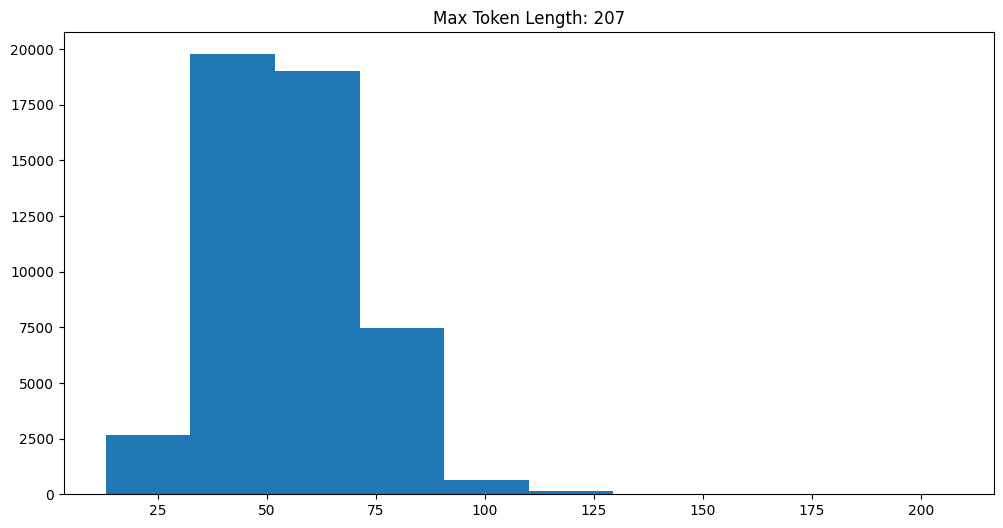

In [18]:
all_captions_length = [
    len(processor.tokenizer.tokenize(l['quality_description']))
    for i in range(len(train_data))
    for l in train_data[i]['ann_list']
]

plt.figure(figsize=(12,6))
plt.hist(x=all_captions_length)
plt.title(f'Max Token Length: {max(all_captions_length)}');

### **Hyperparameter Configs**

In [20]:
epochs = 1
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,weight_decay=0.05,betas=(0.9,0.999))
num_training_steps = epochs * len(trainloader)
num_warmup_steps = int(0.1 * num_training_steps)  
scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)
grad_clip = 1.0 
best_val_loss = float('inf')

In [21]:
accelerator = Accelerator(mixed_precision="fp16",gradient_accumulation_steps=1) 

model, optimizer, trainloader, valloader, scheduler = accelerator.prepare(
    model, optimizer, trainloader, valloader, scheduler
)

In [22]:
total_steps = len(trainloader)
validate_every = total_steps // 4

### Model Training and Evaluation

In [ ]:
for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for step, batch in enumerate(progress_bar, 1):
        optimizer.zero_grad()
        outputs = model(**{k: batch[k] for k in ['input_ids','attention_mask','pixel_values','labels']}, return_dict=False)
        loss = outputs[0]
        accelerator.backward(loss)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        if step % validate_every == 0 or step == len(trainloader):
            model.eval(); val_loss = 0.0
            with torch.no_grad():
                for val_batch in valloader:
                    out = model(**{k: val_batch[k] for k in ['input_ids','attention_mask','pixel_values','labels']}, return_dict=False)
                    val_loss += out[0].item()
            avg_val = val_loss / len(valloader)
            print(f"\nEpoch {epoch} Step {step}/{len(trainloader)} | Val Loss: {avg_val:.4f}")
            if avg_val < best_val_loss:
                best_val_loss = avg_val
                accelerator.unwrap_model(model).save_pretrained('/kaggle/working/best_model', save_function=accelerator.save, safe_serialization=True)
                print(f"New best model saved (Val Loss: {best_val_loss:.4f})")
            model.train()
    print(f"Epoch {epoch} Completed | Avg Train Loss: {train_loss/len(trainloader):.4f}")

### evaluation

In [18]:
lora_model = PeftModel.from_pretrained(base_model, "/kaggle/input/lora_adapters/other/default/1")

In [29]:
def eval_collate_fn(batch):
    images = [pair['img'] for pair in batch]
    captions = [pair['caption'] for pair in batch]  # Reference captions

    prompt_messages = [
        [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": img},
                    {"type": "text", "text": "Can you describe the quality of the image in detail?"}
                ]
            }
        ]
        for img in images
    ]

    inputs = processor.apply_chat_template(
        prompt_messages,
        add_generation_prompt=True,
        tokenize=True,
        padding='longest',
        truncation=True,
        return_tensors="pt",
        return_dict=True
    )

    return {
        'input_ids': inputs["input_ids"],
        'attention_mask': inputs["attention_mask"],
        'pixel_values': inputs['pixel_values'],
        'captions': captions  
    }

In [30]:
valloader = DataLoader(testset,batch_size=32,shuffle=False,collate_fn=eval_collate_fn)

In [31]:
lora_model.to(device)
lora_model.eval()

all_preds = []
all_refs = []

for batch in tqdm(valloader, desc="Evaluating"):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    pixel_values = batch["pixel_values"].to(device)

    with torch.no_grad():
        generated_ids = lora_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            max_new_tokens=128,
            do_sample=False
        )

    preds = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    all_preds.extend(preds)
    all_refs.extend(batch["captions"])

Evaluating: 100%|██████████| 90/90 [19:03<00:00, 12.71s/it]


In [36]:
all_preds = [t.replace('User:Can you describe the quality of the image in detail?\nAssistant: ','') for t in all_preds]

In [37]:
metric = evaluate.load("rouge")
result = metric.compute(predictions=all_predictions, references=all_labels, use_stemmer=True)
print(f"ROUGE:\n{result}")

ROUGE:
{'rouge1': 0.4766085137200682, 'rouge2': 0.2285911986544874, 'rougeL': 0.3635242025100566, 'rougeLsum': 0.37409706048103597}


### **Saving The Model**

In [39]:
merged_model = lora_model.merge_and_unload()
merged_model = merged_model.to("cpu")

save_dir = "smolvlm_image_cpt_cpu"
merged_model.save_pretrained(save_dir)

processor = AutoProcessor.from_pretrained(model_id)
processor.image_processor.size = {"height": 224, "width": 224}

processor.save_pretrained(save_dir)

['smolvlm_image_cpt_cpu/processor_config.json']

In [40]:
!zip -r /kaggle/working/smolvlm_image_cpt_cpu.zip /kaggle/working/smolvlm_image_cpt_cpu

  adding: kaggle/working/smolvlm_image_cpt_cpu/ (stored 0%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/vocab.json (deflated 59%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/merges.txt (deflated 55%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/processor_config.json (deflated 12%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/tokenizer.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 82%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/tokenizer_config.json (deflated 95%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/added_tokens.json (deflated 86%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/preprocessor_config.json (deflated 54%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/config.json (deflated 69%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/model.safetensors (deflated 14%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/generation_config.json (deflated 26%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/special_tokens_map.json (deflated 81%)
  adding: kaggle/working/smolvlm_image_cpt_cpu/chat_template.jinja (deflated 51%)
